### Importing libraries

In [1]:
import os
import numpy as np
import torch.nn as nn
import torch
import shutil
import random
import pathlib
from tqdm import tqdm
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path

/ediss_data/ediss4/sarosh/anaconda3/envs/miragpu/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROJECT_DIR = "/ediss_data/ediss4/sarosh/mira/Thesis"

### Training = YOLO-Seg (add YOLO OBB and maybe YOLO)

Creating YAML for YOLO Segmentation

In [3]:
def create_yolo_data_yaml(output_path, dataset_dir, class_names):
    """
    Creates a YOLOv11-compatible data.yaml file for segmentation.
    """
    # Convert class_names list to dictionary {0: 'class0', 1: 'class1', ...}
    names_dict = {i: name for i, name in enumerate(class_names)}

    yaml_lines = [
        f"train: {os.path.join(dataset_dir, 'images/train')}",
        f"val: {os.path.join(dataset_dir, 'images/val')}",
        "",
        "names:"
    ]
    for i, name in names_dict.items():
        yaml_lines.append(f"  {i}: {name}")

    yaml_content = "\n".join(yaml_lines)

    with open(output_path, 'w') as f:
        f.write(yaml_content)

    print(f"✅ YOLOv11-Seg data.yaml saved to {output_path}")

create_yolo_data_yaml(
    output_path=PROJECT_DIR + "/yolo_dataset_seg_new/data.yaml",
    dataset_dir=PROJECT_DIR + "/yolo_dataset_seg_new",
    class_names=["builds", "street"]
)

✅ YOLOv11-Seg data.yaml saved to /ediss_data/ediss4/sarosh/mira/Thesis/yolo_dataset_seg_new/data.yaml


YOLO-Seg

In [4]:
!yolo segment train data={PROJECT_DIR}"/yolo_dataset_seg_new/data.yaml" model=yolo11n-seg.pt epochs=80 imgsz=640 name=train_80_new device=0

New https://pypi.org/project/ultralytics/8.3.185 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.180 🚀 Python-3.13.5 torch-2.7.1+cu118 CUDA:0 (Tesla V100-PCIE-16GB, 16151MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/ediss_data/ediss4/sarosh/mira/Thesis/yolo_dataset_seg_new/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name

In [5]:
!yolo segment val model={PROJECT_DIR}"/runs/segment/train_80_new/weights/best.pt" data={PROJECT_DIR}"/yolo_dataset_seg_new/data.yaml" save=True save_txt=True save_conf=True name="val_80_new" save_json

Ultralytics 8.3.180 🚀 Python-3.13.5 torch-2.7.1+cu118 CUDA:0 (Tesla V100-PCIE-16GB, 16151MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,958 parameters, 0 gradients, 10.2 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 1610.9±568.9 MB/s, size: 2562.8 KB)
val: Scanning /ediss_data/ediss4/sarosh/mira/Thesis/yolo_dataset_seg_new/labels/
                 Class     Images  Instances      Box(P          R      mAP50  mWARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
                 Class   

### UNet - Dataset preparation

Dataset preparation

In [3]:
class UNetSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.image_files = sorted(self.images_dir.glob("*.png"))
        # Create a dictionary mapping image filenames to mask filenames
        self.mask_files = {img.stem: self.masks_dir / (img.stem + "_mask.png") for img in self.image_files}
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = self.mask_files[img_path.stem]
        # Debugging: Check if mask file exists
        if not mask_path.exists():
            raise FileNotFoundError(f"Mask file not found: {mask_path}")

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))  # (H, W) with class IDs 0,1,2

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        
        # Ensure image is FloatTensor
        image = image.float()
        
        # Ensure mask is LongTensor for CrossEntropyLoss
        mask = torch.as_tensor(mask, dtype=torch.long)

        return image, mask

Augmentation and Data Loaders

In [4]:
# Training augmentations
train_transform = A.Compose([
    A.Resize(height=640, width=640, interpolation=cv2.INTER_LINEAR, # for images
            mask_interpolation=cv2.INTER_NEAREST),  # for masks
    A.RandomRotate90(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize([0.485, 0.456, 0.406], # imagenet
                         [0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Validation transformations (no augmentation)
val_transform = A.Compose([
    A.Resize(height=640, width=640, interpolation=cv2.INTER_LINEAR, # image resizing
            mask_interpolation=cv2.INTER_NEAREST),  # mask resizing
    A.Normalize([0.485, 0.456, 0.406], # imagenet
                         [0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [9]:
# Create datasets and dataloaders
train_dataset = UNetSegmentationDataset(
    images_dir=PROJECT_DIR + "/unet_dataset_new/images/train/",
    masks_dir=PROJECT_DIR + "/unet_dataset_new/masks/train/",
    transform=train_transform
)

val_dataset = UNetSegmentationDataset(
    images_dir=PROJECT_DIR +"/unet_dataset_new/images/val/",
    masks_dir=PROJECT_DIR +"/unet_dataset_new/masks/val/",
    transform=val_transform
)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train batches: 231, Val batches: 58


In [11]:
images, masks = next(iter(train_loader))
print(f"Image batch shape: {images.shape}, Mask batch shape: {masks.shape}")

Image batch shape: torch.Size([8, 3, 640, 640]), Mask batch shape: torch.Size([8, 640, 640])


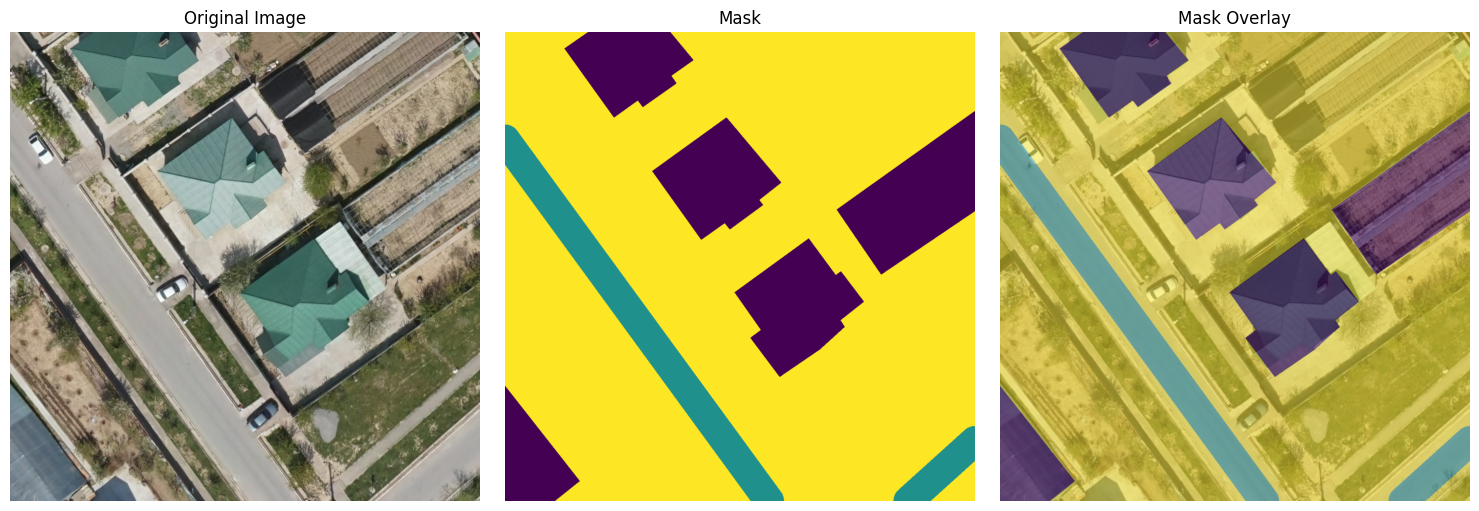

In [9]:
def visualize_sample_by_name(image_path, mask_path, alpha=0.5):
    """
    Visualize a specific image and mask by their paths
    """
    # Read the image
    image = plt.imread(image_path)
    
    # If image has alpha channel, remove it
    if image.shape[-1] == 4:
        image = image[..., :3]
    
    # Read the mask (grayscale)
    mask = plt.imread(mask_path)
    
    # If mask has multiple channels, take the first one
    if len(mask.shape) == 3:
        mask = mask[..., 0]
    
    # Convert mask to class indices (if it's not already)
    if mask.max() <= 1.0:  # If values are between 0-1
        mask = (mask * 255).astype(np.uint8)
    
    # Create a color mask
    num_classes = mask.max() + 1
    cmap = plt.get_cmap('viridis', num_classes)
    colored_mask = cmap(mask / (num_classes - 1))[..., :3]  # Get RGB, ignore alpha
    
    # Create overlay
    overlay = image * (1 - alpha) + colored_mask * alpha
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Mask
    axes[1].imshow(mask, cmap='viridis', vmin=0, vmax=num_classes-1)
    axes[1].set_title('Mask')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(overlay)
    axes[2].set_title('Mask Overlay')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
image_name = "Shymkent_5cm_10_26_tile_0_0.png"  # Change this to your specific image name
mask_name = "Shymkent_5cm_10_26_tile_0_0_mask.png"  # Change this to your specific mask name

image_path = os.path.join(PROJECT_DIR, "yolo_images_Shymkent", image_name)
mask_path = os.path.join(PROJECT_DIR, "unet_masks_Shymkent", mask_name)

visualize_sample_by_name(image_path, mask_path, alpha=0.5)

In [12]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

### UNET basic archetecture (the training function is from kaggle+chatgpt) - using CrossEntropyLoss

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)

        return self.outc(x)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
model = UNet(n_channels=3, n_classes=3).to(DEVICE)  # RGB input, 3 segmentation classes
model = nn.DataParallel(model, device_ids=[0,1,2,3])


Using device: cuda


### Pre-trained UNET model

In [4]:
import torch.nn as nn
from torchvision.models import vgg16_bn

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def conv(in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3,
                stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
     nn.ConvTranspose2d(in_channels, out_channels, 
                         kernel_size=2, stride=2),
     nn.ReLU(inplace=True)
  )

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=3):
        super().__init__()
        self.backbone = vgg16_bn(pretrained=True).features
        self.down1 = nn.Sequential(*self.backbone[:6]) # 64
        self.down2 = nn.Sequential(*self.backbone[6:13]) # 128
        self.down3 = nn.Sequential(*self.backbone[13:20]) # 256
        self.down4 = nn.Sequential(*self.backbone[20:27]) # 512
        self.down5 = nn.Sequential(*self.backbone[27:34]) # 512

        self.bottleneck = nn.Sequential(*self.backbone[34:]) # 512
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv5 = up_conv(1024, 512)
        self.merge_conv5 = conv(512+512, 512)
        self.up_conv4 = up_conv(512, 256)
        self.merge_conv4 = conv(512 + 256, 256)
        self.up_conv3 = up_conv(256, 128)
        self.merge_conv3 = conv(256+128, 128)
        self.up_conv2 = up_conv(128, 64)
        self.merge_conv2 = conv(128+64, 64)
        self.up_conv1 = up_conv(64, 32)
        self.merge_conv1 = conv(32+64, 32)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # encoder
        x_1 = self.down1(x)
        x_2 = self.down2(x_1)
        x_3 = self.down3(x_2)
        x_4 = self.down4(x_3)
        x_5 = self.down5(x_4)
        # bottleneck
        x = self.bottleneck(x_5)
        x = self.conv_bottleneck(x)
        # decoder
        x = self.up_conv5(x)
        x = self.merge_conv5(torch.cat([x, x_5], dim=1))
        x = self.up_conv4(x)
        x = self.merge_conv4(torch.cat([x, x_4], dim=1))
        x = self.up_conv3(x)
        x = self.merge_conv3(torch.cat([x, x_3], dim=1))
        x = self.up_conv2(x)
        x = self.merge_conv2(torch.cat([x, x_2], dim=1))
        x = self.up_conv1(x)
        x = self.merge_conv1(torch.cat([x, x_1], dim=1))

        x = self.final_conv(x)
        return x

model = UNet(pretrained=True, out_channels=3).to(DEVICE)
model = nn.DataParallel(model, device_ids=[0,1,2,3])

/ediss_data/ediss4/sarosh/anaconda3/envs/miragpu/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ediss_data/ediss4/sarosh/anaconda3/envs/miragpu/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### UNET training

In [20]:
n_classes = 3  # Number of segmentation classes
# CrossEntropy loss function with IoU and Dice metrics
ce_loss = nn.CrossEntropyLoss()
eps = 1e-6
def loss_fn(preds, targets):
    loss = ce_loss(preds, targets)

    preds_labels = torch.argmax(preds, dim=1)

    acc = (preds_labels == targets).float().mean()

    # --- IoU & Dice for all classes ---
    ious, dices = [], []
    precisions, recalls = [], []
    for cls in range(n_classes):
        pred_cls = (preds_labels == cls).float()
        target_cls = (targets == cls).float()

        TP = (pred_cls * target_cls).sum()
        FP = (pred_cls * (1 - target_cls)).sum()
        FN = ((1 - pred_cls) * target_cls).sum()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum() - intersection
        if pred_cls.sum() + target_cls.sum() == 0:
            iou, dice = torch.tensor(0.0, device=DEVICE), torch.tensor(0.0, device=DEVICE)
        else:
            iou = intersection / (union + eps)
            dice = (2 * intersection) / (pred_cls.sum() + target_cls.sum() + eps)
        # Precision & Recall
        precision = TP / (TP + FP + eps)
        recall = TP / (TP + FN + eps)

        if cls != 2:  # skip background from mean
            ious.append(iou)
            dices.append(dice)
            precisions.append(precision)
            recalls.append(recall)

    mean_iou = torch.mean(torch.stack(ious)) if ious else torch.tensor(0.0, device=DEVICE)
    mean_dice = torch.mean(torch.stack(dices)) if dices else torch.tensor(0.0, device=DEVICE)
    mean_precision = torch.mean(torch.stack(precisions)) if precisions else torch.tensor(0.0, device=DEVICE)
    mean_recall = torch.mean(torch.stack(recalls)) if recalls else torch.tensor(0.0, device=DEVICE)

    return loss, acc.item(), mean_iou.item(), mean_dice.item(), mean_precision.item(), mean_recall.item()

def train_batch(model, batch, optim, loss_fn):
    model.train()
    imgs, masks = [t.to(DEVICE) for t in batch] 
    pred_masks = model(imgs)
    optim.zero_grad()
    loss, acc, iou, dice, precision, recall = loss_fn(pred_masks, masks)
    loss.backward()
    optim.step()
    return loss.item(), acc, iou, dice, precision, recall

In [21]:
import torch.distributed as dist

def is_main_process():
    # In Jupyter (single process) this returns True.
    # In DDP (if you ever switch), it will be True only on rank 0.
    return (not dist.is_available()) or (not dist.is_initialized()) or dist.get_rank() == 0

def log(*args, **kwargs):
    if is_main_process():
        print(*args, **kwargs)

In [ ]:
@torch.no_grad()
def validate_epoch(model, val_loader, loss_fn, save_preds=False, save_dir=None, epoch=None):
    model.eval()

    # Accumulators
    all_preds, all_targets = [], []
    val_loss_sum = 0.0
    N = len(val_loader)

    for i, (imgs, masks) in enumerate(val_loader):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)

        # Loss
        loss, _, _, _, _, _ = loss_fn(preds, masks)
        val_loss_sum += loss.item()

        # Save for epoch-level metrics
        all_preds.append(torch.argmax(preds, dim=1).cpu())
        all_targets.append(masks.cpu())

        # ---- Save predictions & inputs ----
        if is_main_process() and save_preds and save_dir is not None:
            os.makedirs(save_dir, exist_ok=True)
            preds_labels = torch.argmax(preds, dim=1).cpu()

            for j in range(imgs.size(0)):
                img = imgs[j].cpu().permute(1, 2, 0).numpy()  # CHW → HWC
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # normalize 0–1
                img = (img * 255).astype("uint8")

                pred_mask = preds_labels[j].numpy().astype("uint8")
                gt_mask = masks[j].cpu().numpy().astype("uint8")

                # Save each separately
                Image.fromarray(img).save(
                    os.path.join(save_dir, f"val_{i}_{j}_image.png"))
                Image.fromarray(pred_mask).save(
                    os.path.join(save_dir, f"val_{i}_{j}_pred.png"))
                Image.fromarray(gt_mask).save(
                    os.path.join(save_dir, f"val_{i}_{j}_gt.png"))

                # ---- OPTIONAL: side-by-side visualization ----
                stacked = np.concatenate([
                    img,
                    np.stack([pred_mask * 80] * 3, axis=-1),  # colorize pred
                    np.stack([gt_mask * 80] * 3, axis=-1)     # colorize GT
                ], axis=1)
                Image.fromarray(stacked.astype("uint8")).save(
                    os.path.join(save_dir, f"val_{i}_{j}_stacked.png"))

    # Concatenate all predictions/targets
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # ---- Epoch-level Metrics ----
    acc = (all_preds == all_targets).float().mean().item()

    ious, dices = [], []
    per_class_iou, per_class_dice = {}, {}
    for cls in range(n_classes):
        pred_cls = (all_preds == cls).float()
        target_cls = (all_targets == cls).float()

        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum() - intersection

        if pred_cls.sum() + target_cls.sum() == 0:
            iou, dice = torch.tensor(0.0), torch.tensor(0.0)
        else:
            iou = intersection / (union + eps)
            dice = (2 * intersection) / (pred_cls.sum() + target_cls.sum() + eps)
        per_class_iou[cls] = iou.item()
        per_class_dice[cls] = dice.item()

        if cls != 2:  # skip background in mean
            ious.append(iou)
            dices.append(dice)

    mean_iou = torch.mean(torch.stack(ious)).item() if ious else 0.0
    mean_dice = torch.mean(torch.stack(dices)).item() if dices else 0.0

    avg_val_loss = val_loss_sum / N

    return avg_val_loss, acc, mean_iou, mean_dice, per_class_iou, per_class_dice


In [26]:
save_dir = PROJECT_DIR + "/training_20_pretrained_cosine_check"
os.makedirs(save_dir, exist_ok=True)

n_epochs = 20  # Number of training epochs
unfreeze_epoch = 5  # epoch to unfreeze encoder

# ---- Freeze encoder before training ----
for param in model.module.backbone.parameters():
    param.requires_grad = False
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
# Cosine annealing scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, T_max=n_epochs, eta_min=1e-6   # eta_min = minimum LR
)
# ---- Logs ----
train_losses, train_accs, train_ious, train_dices, train_precision, train_recall = [], [], [], [], [], []
val_losses, val_accs, val_ious, val_dices = [], [], [], []

for e in range(n_epochs):
    if e == unfreeze_epoch:
        print("Unfreezing encoder...")
        for param in model.module.backbone.parameters():
            param.requires_grad = True
    # Training
    trn_loss_sum, trn_acc_sum, trn_iou_sum, trn_dice_sum, trn_precision_sum, trn_recall_sum = 0, 0, 0, 0, 0, 0
    N = len(train_loader)
    for batch in train_loader:
        loss, acc, iou, dice, precision, recall = train_batch(model, batch, optim, loss_fn)
        trn_loss_sum += loss
        trn_acc_sum += acc
        trn_iou_sum += iou
        trn_dice_sum += dice
        trn_precision_sum += precision
        trn_recall_sum += recall
    avg_trn_loss = trn_loss_sum / N
    avg_trn_acc = trn_acc_sum / N
    avg_trn_iou = trn_iou_sum / N
    avg_trn_dice = trn_dice_sum / N
    avg_trn_precision = trn_precision_sum / N
    avg_trn_recall = trn_recall_sum / N

    train_losses.append(avg_trn_loss)
    train_accs.append(avg_trn_acc)
    train_ious.append(avg_trn_iou)
    train_dices.append(avg_trn_dice)
    train_precision.append(avg_trn_precision)
    train_recall.append(avg_trn_recall)

    # Validation
    save_preds = (e == n_epochs - 1)
    save_preds_dir = os.path.join(save_dir, f"val_predictions_epoch_{e+1}") if save_preds else None

    avg_val_loss, avg_val_acc, avg_val_iou, avg_val_dice, val_iou_per_cls, val_dice_per_cls = validate_epoch(
        model, val_loader, loss_fn, save_preds=save_preds, save_dir=save_preds_dir, epoch=e+1
    )

    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)
    val_ious.append(avg_val_iou)
    val_dices.append(avg_val_dice)


    print(f"Epoch {e+1}/{n_epochs} - "
          f"Train Loss: {avg_trn_loss:.4f}, Train Acc: {avg_trn_acc:.4f}, "
          f"Train IoU: {avg_trn_iou:.4f}, Train Dice: {avg_trn_dice:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}, "
          f"Val IoU: {avg_val_iou:.4f}, Val Dice: {avg_val_dice:.4f} |"
          f"LR: {scheduler.get_last_lr()[0]:.6f}")
    print("Per-class IoU:", val_iou_per_cls)
    print("Per-class Dice:", val_dice_per_cls)

    # Step the scheduler
    scheduler.step()
    
    # Save weights
    torch.save(model.state_dict(), os.path.join(save_dir, f"unet_epoch_{e+1}.pth"))

# ---- Save all metrics ----
torch.save({
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs,
    "train_ious": train_ious,
    "val_ious": val_ious,
    "train_dices": train_dices,
    "val_dices": val_dices
}, os.path.join(save_dir, "metrics.pth"))

Epoch 1/20 - Train Loss: 0.1111, Train Acc: 0.9642, Train IoU: 0.7493, Train Dice: 0.8488 | Val Loss: 0.1463, Val Acc: 0.9493, Val IoU: 0.6737, Val Dice: 0.7978 |LR: 0.000100
Per-class IoU: {0: 0.8037817478179932, 1: 0.5436015725135803, 2: 0.9404128193855286}
Per-class Dice: {0: 0.8912184238433838, 1: 0.7043288350105286, 2: 0.9692915081977844}
Epoch 2/20 - Train Loss: 0.1063, Train Acc: 0.9649, Train IoU: 0.7531, Train Dice: 0.8512 | Val Loss: 0.1670, Val Acc: 0.9399, Val IoU: 0.6216, Val Dice: 0.7603 |LR: 0.000099
Per-class IoU: {0: 0.7381762266159058, 1: 0.5050907731056213, 2: 0.9307018518447876}
Per-class Dice: {0: 0.849368691444397, 1: 0.6711764931678772, 2: 0.9641072750091553}
Epoch 3/20 - Train Loss: 0.0977, Train Acc: 0.9672, Train IoU: 0.7663, Train Dice: 0.8597 | Val Loss: 0.1462, Val Acc: 0.9495, Val IoU: 0.6737, Val Dice: 0.7971 |LR: 0.000098
Per-class IoU: {0: 0.8096172213554382, 1: 0.5376887917518616, 2: 0.9405264854431152}
Per-class Dice: {0: 0.8947939276695251, 1: 0.6993

### Visualizing losses, IoU, Dice of UNET

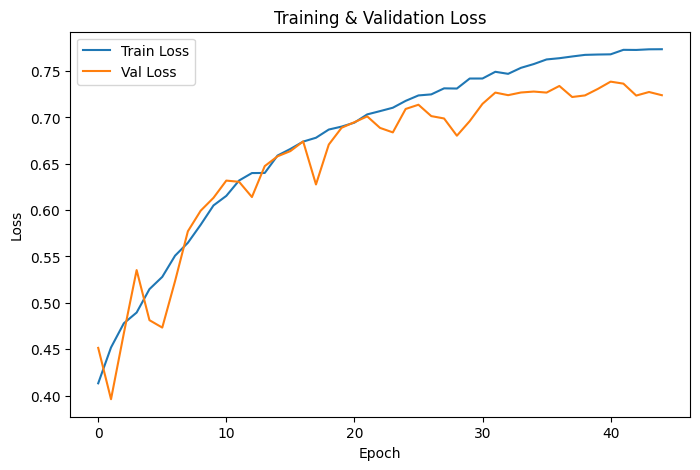

In [14]:
# Load metrics
metrics = torch.load(PROJECT_DIR + "/training_logs_45_cosine_annealing/metrics.pth")

train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
train_accs = metrics["train_accs"]
val_accs = metrics["val_accs"]
train_ious = metrics["train_ious"]
val_ious = metrics["val_ious"]
train_dices = metrics["train_dices"]
val_dices = metrics["val_dices"]

# Example: plot loss
plt.figure(figsize=(8,5))
plt.plot(train_ious, label="Train Loss")
plt.plot(val_ious, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

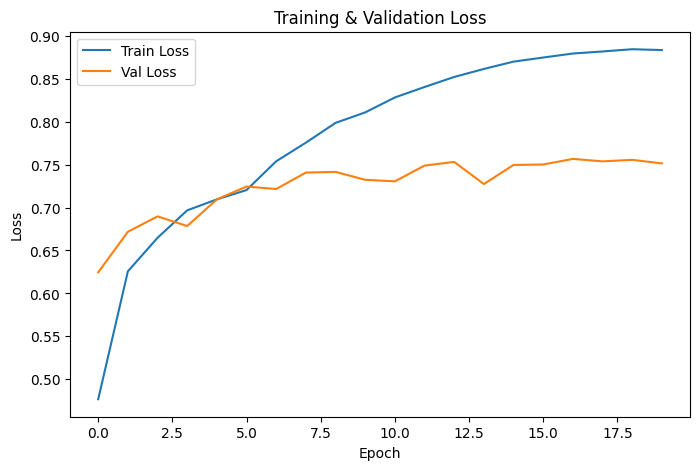

In [14]:
# Load metrics
metrics = torch.load(PROJECT_DIR + "/training_logs_20_pretrained_cosine/metrics.pth")

train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
train_accs = metrics["train_accs"]
val_accs = metrics["val_accs"]
train_ious = metrics["train_ious"]
val_ious = metrics["val_ious"]
train_dices = metrics["train_dices"]
val_dices = metrics["val_dices"]

# Example: plot loss
plt.figure(figsize=(8,5))
plt.plot(train_ious, label="Train Loss")
plt.plot(val_ious, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

Visualize predicted and gt masks

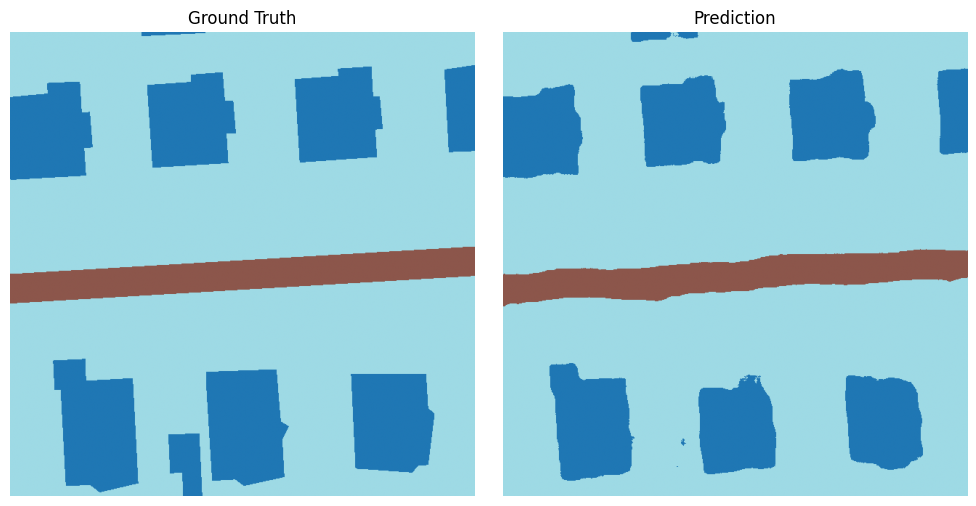

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def visualize_mask_comparison(idx, save_preds_dir, cmap="tab20"):
    """
    Visualize ground truth vs predicted mask side by side.

    Args:
        idx (tuple or str): tuple (i, j) from validation saving loop 
                            OR base name like "val_0_3".
        save_preds_dir (str): directory where predictions were saved.
        cmap (str): matplotlib colormap for masks (default: 'tab20').
    """
    if isinstance(idx, tuple):
        base_name = f"val_{idx[0]}_{idx[1]}"
    else:
        base_name = idx

    gt_path = os.path.join(save_preds_dir, f"{base_name}_gt.png")
    pred_path = os.path.join(save_preds_dir, f"{base_name}_pred.png")

    if not (os.path.exists(gt_path) and os.path.exists(pred_path)):
        print(f"Missing files for {base_name}")
        return

    gt = Image.open(gt_path)
    pred = Image.open(pred_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(gt, cmap=cmap, vmin=0)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")

    axes[1].imshow(pred, cmap=cmap, vmin=0)
    axes[1].set_title("Prediction")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Example: show masks for batch 0, sample 2
visualize_mask_comparison((49, 6), os.path.join(PROJECT_DIR, "training_20_pretrained_cosine_check/val_predictions_epoch_20"))

### YOLO-Seg visualization

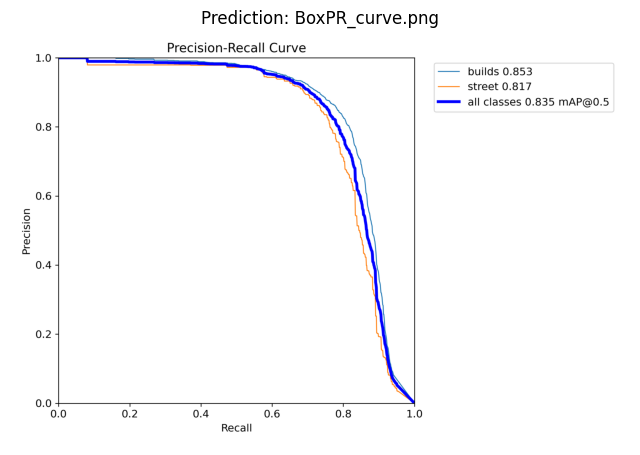

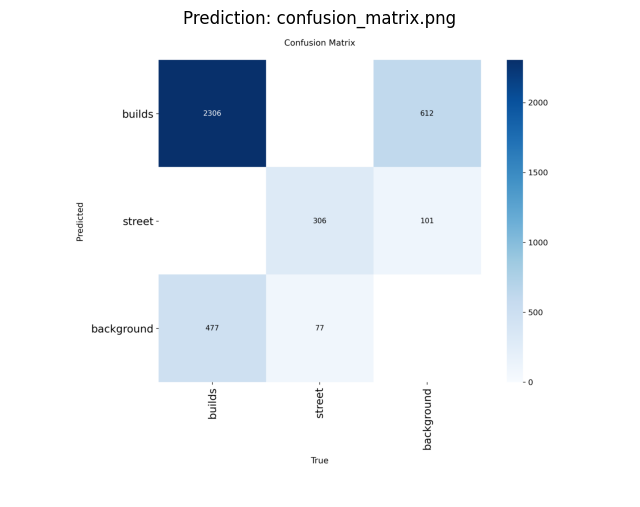

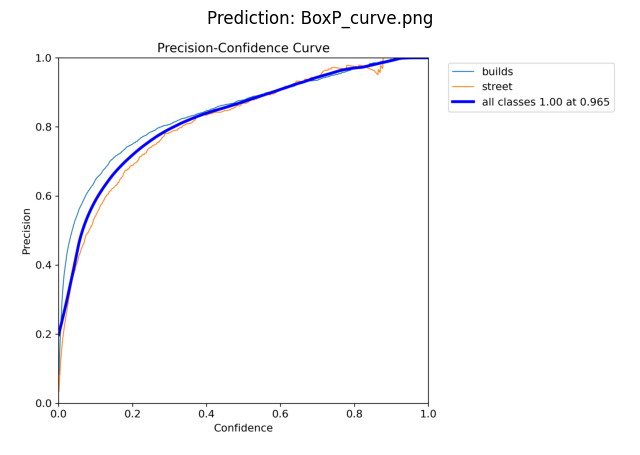

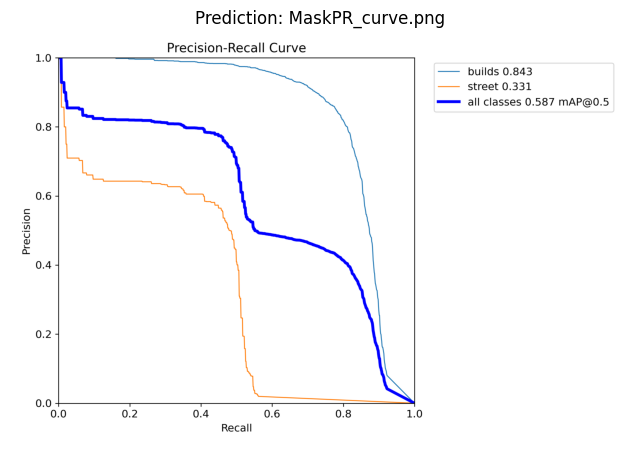

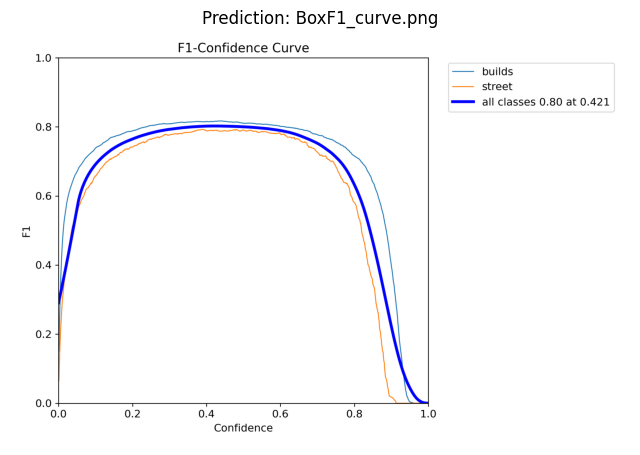

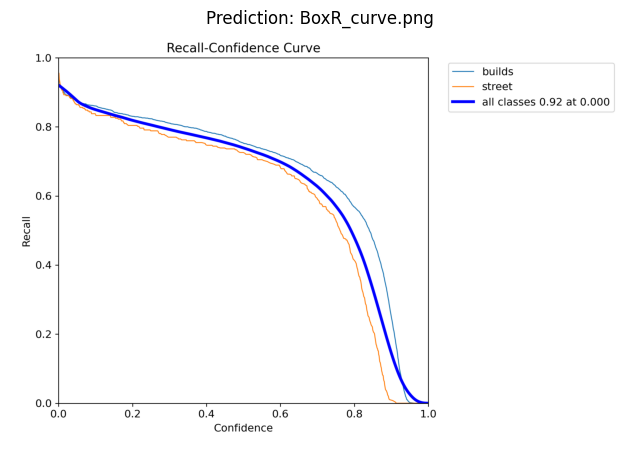

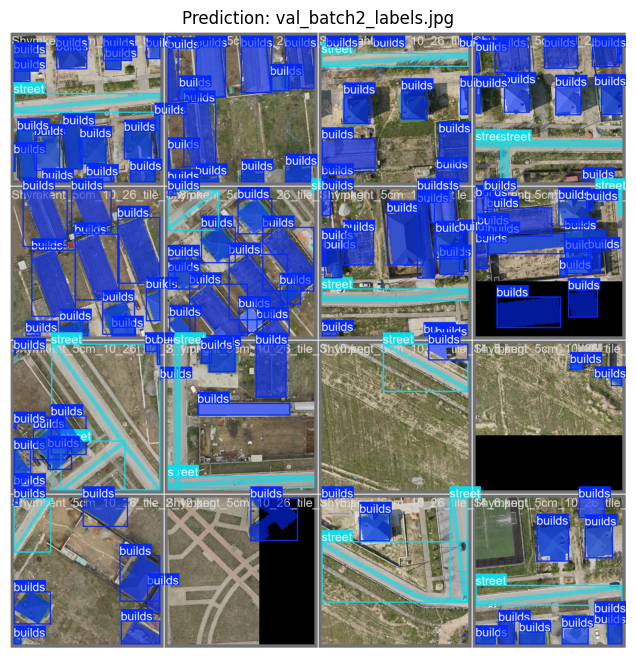

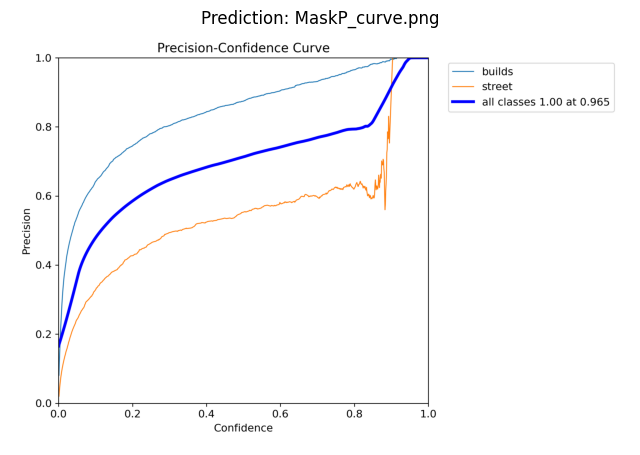

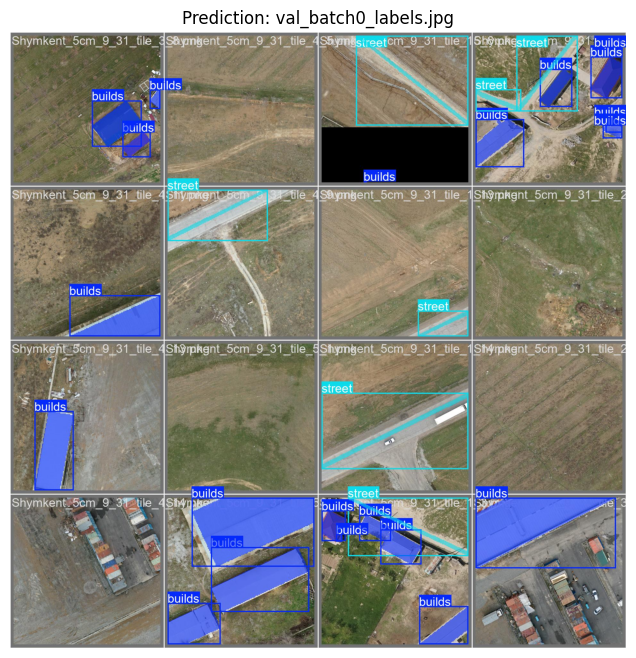

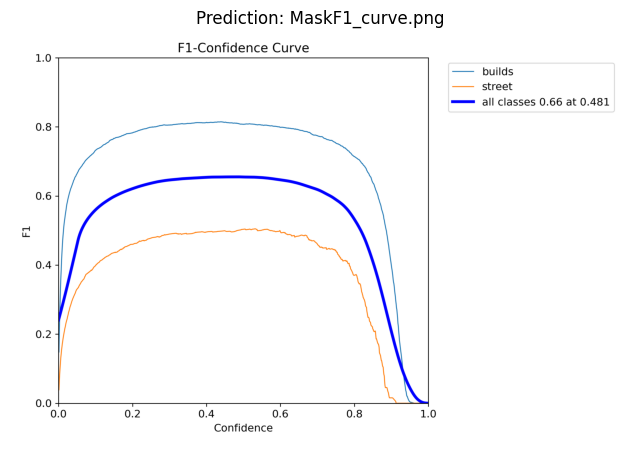

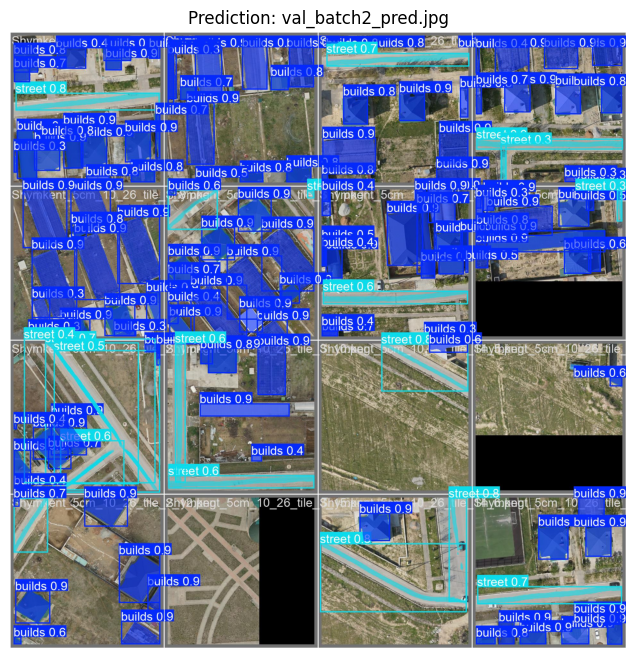

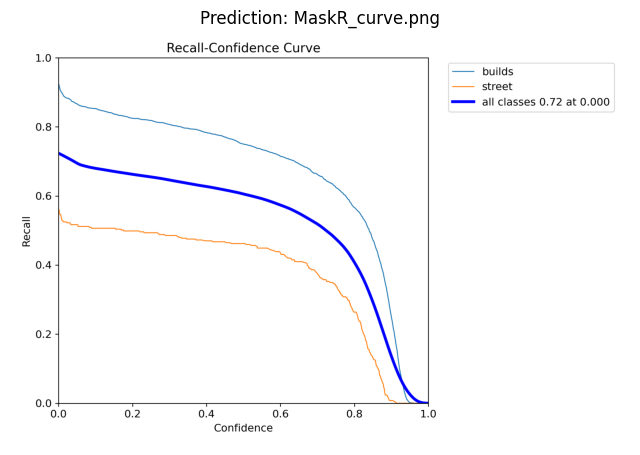

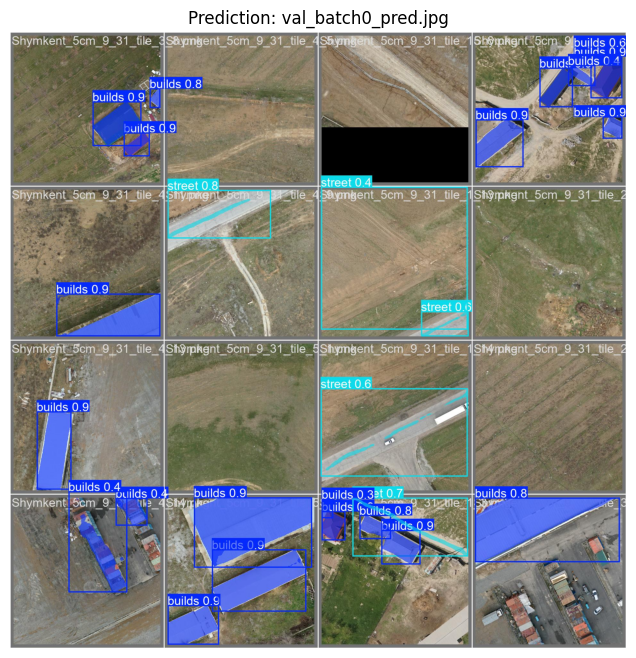

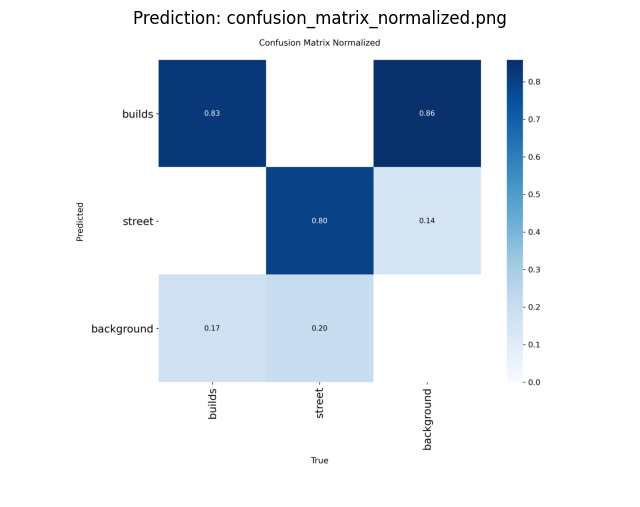

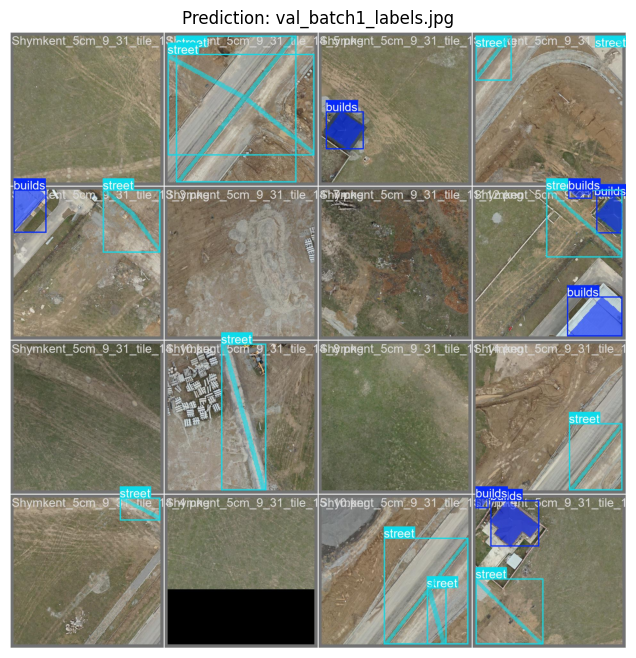

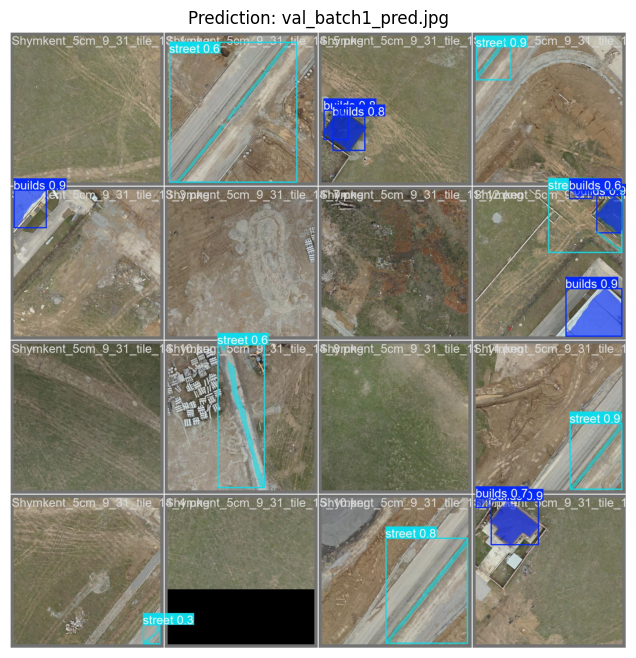

In [64]:
# Define the directory where validation results are saved (adjust if needed)
results_dir = PROJECT_DIR + '/runs/segment/val_80'  # Adjust with your results directory

# List the images in the result folder
image_files = [f for f in os.listdir(results_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Loop through each image and plot it
for img_file in image_files:
    img_path = os.path.join(results_dir, img_file)

    # Read the image with OpenCV
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

    # Plot the image with matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')  # Hide axes for better visualization
    plt.title(f"Prediction: {img_file}")
    plt.show() 